<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/experiments/advanced_computer_vision_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Deep Learning for Computer Vision (v2)
In this notebook we deal with another fundamental tasks in computer vision: semantic segmentation. In semantic segmentation each pixel of an image is assigned a class so that each pixel is part of a group and the image is separated in clusters of pixels. The semantic segmentation assigns the same value to all the pixels of a certain class even if they belong to different objects of the same type. In a slightly different task, named instance segmentation, the algorithm is able to classify a pixel and also tell which cluster it belongs to. An object detection algorithm is able to detect the location of the object in the image by adding a bounding box around it with a label for its class.

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import time

## Semantic segmentation
We will use the [Oxford-IIIT Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. it contains 7390 JPG RGB images with 8 bit depth so that the pixel value ranges between 0 and 255. Each image has a corresponding target raster PNG image of the same size, i.e. height and width, of the input image where each pixel can take one of three values

* 1 for the foreground
* 2 for the background
* 3 for the contour

We download and untar the input images and the annotated raster files.  

In [2]:
!wget -q --show-progress http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -q --show-progress http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz;
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

images.tar.gz       100%[===================>] 755.23M  24.6MB/s    in 30s     
annotations.tar.gz  100%[===================>]  18.28M  10.3MB/s    in 1.8s    


After unzipping the data, we have two folders: one, _images/_, that contains all the jpg images and the other, _annotations/trimaps/_, that contains the corresponding masks. We open one image and its mask. We can see that they have the same size, i.e. height and width. The mask has only one channel.

In [3]:
DATA_DIR = '.'

In [4]:
from PIL import Image
img = Image.open(DATA_DIR + '/images/Abyssinian_1.jpg')
img.size

(600, 400)

In [5]:
annotation = Image.open(DATA_DIR + '/annotations/trimaps/Abyssinian_1.png')
annotation.size

(600, 400)

In [6]:
np.unique(annotation)

array([1, 2, 3], dtype=uint8)

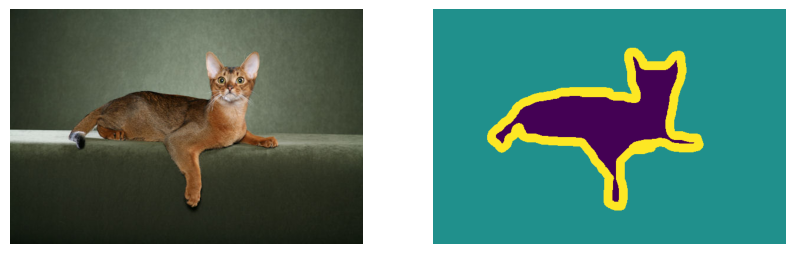

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(img)
ax[1].imshow(annotation)

## Creating the datasets
The first step to create the datasets to be used as input of a model is to collect the path to the images and masks as lists

In [8]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_file_list = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")]
input_img_paths = sorted(input_file_list)
num_images = len(input_img_paths)
print('Number of images: {:d}'.format(num_images))

Number of images: 7390


In [9]:
target_file_list = [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")]
target_paths = sorted(target_file_list)
print('Number of masks: {:d}'.format(len(target_paths)))

Number of masks: 7390


We shuffle the images before creating the datasets

In [10]:
import random
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

We split the images into a train, validation, and test set

In [11]:
size_train_set = 5920
size_val_set = 736
size_test_set = num_images - size_train_set - size_val_set
train_images = input_img_paths[:size_train_set]
val_images = input_img_paths[size_train_set:size_train_set + size_val_set]
test_images = input_img_paths[size_train_set + size_val_set:]
len(train_images)

5920

we do the same for the masks as well

In [12]:
train_masks = target_paths[:size_train_set]
val_masks = target_paths[size_train_set:size_train_set + size_val_set]
test_masks = target_paths[size_train_set + size_val_set:]
len(train_masks)

5920

Since using arrays to store the images and the masks of the Oxford pets takes 3.6 GB of memory space in this notebook we instead define a function to create a TF datasets for training, validation and test sets,

In [13]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None):

    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf.io.read_file(input_img_path)
        input_img = tf.io.decode_png(input_img, channels=3) # transforms a png file into a tensor
        input_img = tf.image.resize(input_img, img_size)
        input_img = tf.image.convert_image_dtype(input_img, 'float32')

        target_img = tf.io.read_file(target_img_path)
        target_img = tf.io.decode_png(target_img, channels=1)
        target_img = tf.image.resize(target_img, img_size, method="nearest") # Resize mask to match model output keeping the original Corine2018 values
        target_img = tf.image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1,2,3. Subtract 1 to make them 0,1,2:
        target_img -= 1
        return input_img, target_img

    dataset = tf.data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size)

In [14]:
img_size = (200, 200)
batch_size = 64

We load the images and masks for training into a Tensorflow dataset

In [15]:
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_images,
    train_masks
)

We have a look at the content of the dataset, to be sure the train dataset is in the right shape: a tensor of batches containing tuples of image and mask pairs.

In [22]:
def print_input_tuple(ds):
    print('Number of batches: ', len(ds))
    image_mask_tuple = ds.take(1).get_single_element() # 1st tuple of the dataset containing a batch of images and a batch of masks
    image_batch = image_mask_tuple[0]
    mask_batch = image_mask_tuple[1]
    print('Batch image shape: {}\nBatch mask shape: {}'.format(image_batch.shape, mask_batch.shape))
    image = image_batch[1]
    mask = mask_batch[1]
    print('Image min: {}, image max: {}'.format(image.numpy().min(), image.numpy().max()))
    print('Mask min: {}, mask max: {}'.format(mask.numpy().min(), mask.numpy().max()))
    print('Unique mask values: {}'.format(np.unique(mask)))

In [23]:
print_input_tuple(train_dataset)

Number of batches:  93
Batch image shape: (64, 200, 200, 3)
Batch mask shape: (64, 200, 200, 1)
Image min: 0.0, image max: 255.0
Mask min: 0, mask max: 2
Unique mask values: [0 1 2]


In [24]:
def plot_tensor_in_dataset(ds, img_index=0, print_info=True):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    img_t = None
    msk_t = None
    tuples = ds.take(1).get_single_element() # extracts the 1st batch from the dataset and returns its tuples of (image, mask) pairs

    images = tuples[0]
    img_t = images[img_index]
    if (print_info):
      print('Image type: ', type(img_t))
      print('Image tensor data type: ', img_t.dtype)
      print('Image tensor shape: ', img_t.shape)


    pil_image = tf.keras.utils.array_to_img(img_t)
    img_array = np.asarray(pil_image)
    if (print_info):
      print('Image tensor min {:.2f} and max {:.2f}'.format(img_array.min(), img_array.max()))

    masks = tuples[1]
    msk_t = masks[img_index]
    if (print_info):
      print('Mask type: ', type(msk_t))
      print('Mask tensor data type: ', msk_t.dtype)
      print('Mask tensor shape: ', msk_t.shape)
      print('Mask tensor unique values: ', np.unique(msk_t))

    pil_mask = tf.keras.utils.array_to_img(msk_t)
    msk_array = np.asarray(pil_mask)

    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].imshow(pil_image)
    ax[1].imshow(pil_mask)

We can also check visually that the tuples in the first batch are well set up, that is, they contain  an image and its corresponding mask with the right shapes and data types.

Image type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Image tensor data type:  <dtype: 'float32'>
Image tensor shape:  (200, 200, 3)
Image tensor min 0.00 and max 255.00
Mask type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Mask tensor data type:  <dtype: 'uint8'>
Mask tensor shape:  (200, 200, 1)
Mask tensor unique values:  [0 1 2]


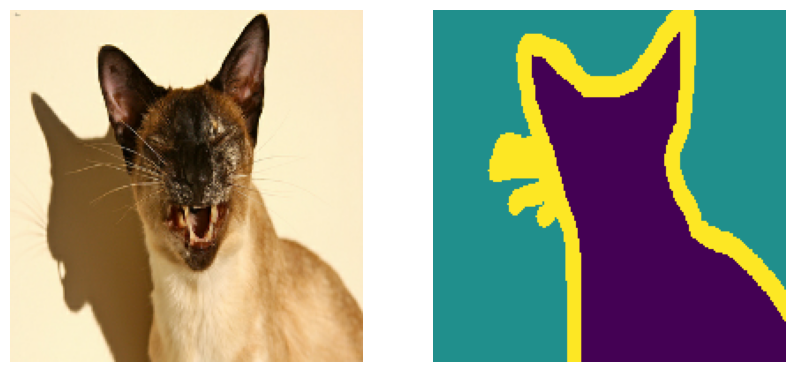

In [25]:
plot_tensor_in_dataset(train_dataset, img_index = 63)

Now, let's say we want to apply a trasnformation to the dataset. We can use the map() method of the Tensorflow Dataset to apply the transfomation to all the elements of a dataset. The map() method returns a new dataset that can be concatenated to the original dataset. We can implement a data augmentation technique following this approach.

In [26]:
def flip_up_down(img):
        img_flip = tf.image.flip_up_down(img)
        return img_flip

In [27]:
flip_dataset = train_dataset.map(lambda x, y: (flip_up_down(x), flip_up_down(y)))

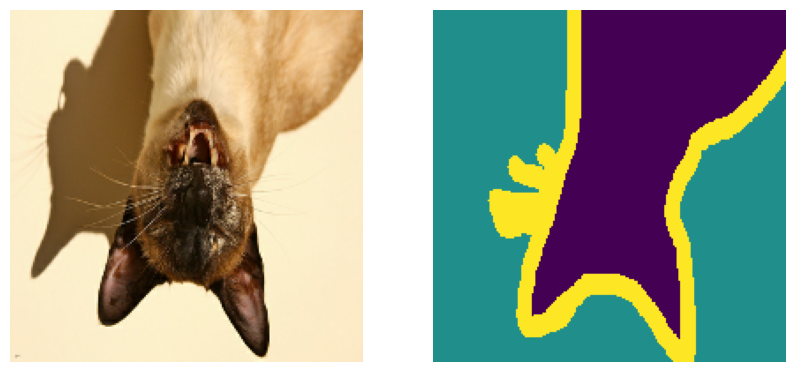

In [28]:
plot_tensor_in_dataset(flip_dataset, img_index = 63, print_info=False)

Before applying an augementation step to the train dataset we load the other two datasets for validation and test

In [29]:
val_dataset = get_dataset(
    batch_size,
    img_size,
    val_images,
    val_masks
)

In [30]:
test_dataset = get_dataset(
    batch_size,
    img_size,
    test_images,
    test_masks
)

## Data augmentation
We apply some transformations to the training set to increase the number of examples

In [31]:
def augment_dataset(ds):

    def flip_up_down(img):
        img_flip = tf.image.flip_up_down(img)
        return img_flip

    def flip_left_right(img):
        img_flip = tf.image.flip_left_right(img)
        return img_flip

    def rotate90(img):
        img_rotated = tf.image.rot90(img)
        return img_rotated

    r_ds = ds.map(lambda x, y: (rotate90(x), rotate90(y)), num_parallel_calls=tf.data.AUTOTUNE)
    fud_ds = ds.map(lambda x, y: (flip_up_down(x), flip_up_down(y)), num_parallel_calls=tf.data.AUTOTUNE)
    flr_ds = ds.map(lambda x, y: (flip_left_right(x), flip_left_right(y)), num_parallel_calls=tf.data.AUTOTUNE)

    fud_flr_ds = fud_ds.concatenate(flr_ds)
    rs_fud_flr_ds = fud_flr_ds.concatenate(r_ds)
    all_ds = ds.concatenate(rs_fud_flr_ds)

    return all_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

We can see that we have 4 times the number of train batches we had before the augmentation step

In [32]:
aug_train_ds = augment_dataset(train_dataset)
print('Number of batches in the augmented train dataset: ', len(aug_train_ds))

Number of batches in the augmented train dataset:  372


## Building the model
Now we define the model. The size of the input images is 200x200 and after a normalization of the values we apply 6 convolutional layers and 6 transposed convolutional layers. We use padding "same" in all the convolutional layer.

In [34]:
def build_model(img_size, num_classes):
    kernal_size = (3, 3)
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, kernal_size, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, kernal_size, strides=2, activation="relu", padding="same")(x)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

The first part of the model, let's call it the encoder, uses convolutional layers in a way similar to that we used for image classification: we reduce the size of the feature maps and increase their number from the 3 RGB channels to 256 filters. The reduction of the height and width is done using a stride 2 instead of a MaxPooling layer. This technique preserves a feature's location since it is relevant for a segmentation task. The second part of the model, let's call it the decoder, uses a different type of convolutional layer called transpose and the number of feature maps decreases while their size increases till becoming of the same size of the input. The purpose of the decoder part is to learn how to upsample the feature maps so that it can apply the information learnt from the encoder to each pixel in the input image.

![segmentation architecture](https://github.com/luigiselmi/dl_tensorflow/blob/main/images/segmentation_architecture.jpg?raw=1)

For the 1st convolutional layer the kernel size is k = 3 with strides s = 2 so we are in a zero padding, p = 1, non-unit strides case and the output size is

$$o = \frac {i + 2p - k}{s} + 1 = \frac {200 + 2 - 3}{2} + 1 = 99 + 1 = 100$$

where we have calculated the minimum integer of the fraction. The 2nd convolutional layer is a zero padding p = 1, unit strides s = 1 so the size of the output is

$$o = (i - k) + 2p + 1 = (100 - 3) + 2 + 1 = 100$$

So the output of the 2nd convolutional layer has the same height and width of the input and also the number of filters is the same. The logic for the encoder part of the architecture is the same for the next 4 convolutional layers: a reduction of the height and width and an increase of the number of filters. Now we move to the decoder part to do the arithmetic for the transposed convolutions. We start from the last convolutional layer of the encoder with size 25 x 25 and 256 filters. The purpose now is to project the feature maps to a higher-dimensional space, e.g. from 25 x 25 to 50 x 50. The 1st transposed convolution is a zero padding p = 1, unit strides s = 1 case and the output size is the same as the input, that is 25 x 25. The strides of the 2nd transposed convolution is s = 2 with zero padding p = 1 so the output size is

$$o = s(i - 1) + k - 2p = 2(25 - 1) + 3 - 2 = 49 (+ 1) = 50$$

We add 1 to the result since $i + 2p -k == sm$ where m is an integer. In other words $i + 2p -k$ must be a multiple of s. The number of filters of the 2nd transposed convolution is still 256. The logic for the transposed convolution applies for the next 4 transposed convolutions till the last one where we have the same shape as the input, 200 x 200, and 3 filters.

In [35]:
model = build_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

We compile the model and define the callbacks to be used for the training. At each epoch we save the weights if the validation loss is lower than before. We use the [sparse categorical cross-entropy](https://keras.io/api/losses/probabilistic_losses/#sparse_categorical_crossentropy-function) function for the multi-class classification of the pixels in one of the three classes: foreground, background, and contour.

In [36]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
    save_best_only=True)
]

We fit the model using the augmented train dataset

In [37]:
history = model.fit(aug_train_ds,
                    epochs=40,
                    callbacks=callbacks,
                    batch_size=None,
                    validation_data=val_dataset)

Epoch 1/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 270s 589ms/step - accuracy: 0.6080 - loss: 0.9108 - val_accuracy: 0.7018 - val_loss: 0.7310
Epoch 2/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 189s 508ms/step - accuracy: 0.7365 - loss: 0.6376 - val_accuracy: 0.7556 - val_loss: 0.5929
Epoch 3/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 189s 508ms/step - accuracy: 0.7931 - loss: 0.5173 - val_accuracy: 0.7960 - val_loss: 0.5118
Epoch 4/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 189s 508ms/step - accuracy: 0.8205 - loss: 0.4543 - val_accuracy: 0.8078 - val_loss: 0.4826
Epoch 5/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 189s 508ms/step - accuracy: 0.8360 - loss: 0.4175 - val_accuracy: 0.8105 - val_loss: 0.4748
Epoch 6/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 189s 508ms/step - accuracy: 0.8472 - loss: 0.3901 - val_accuracy: 0.8160 - val_loss: 0.4621
Epoch 7/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 189s 508ms/step - accuracy: 0.8541 - loss: 0.3737 - val_accuracy: 0.8259 - val_loss: 0.4365
Epoch 8/40
372/372 ━━━━━━━━━━━━━━━━━━━━ 189s 509ms/step - accuracy: 0.8626 -

In [38]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

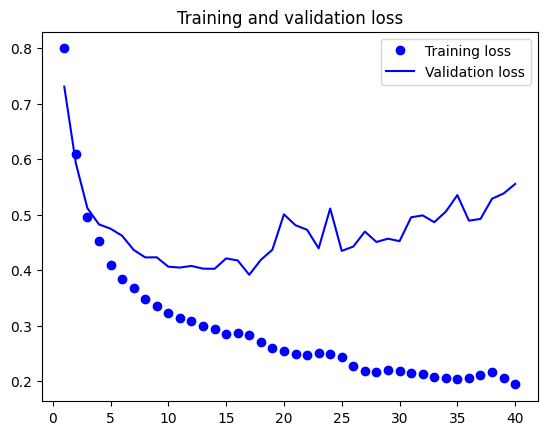

In [39]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

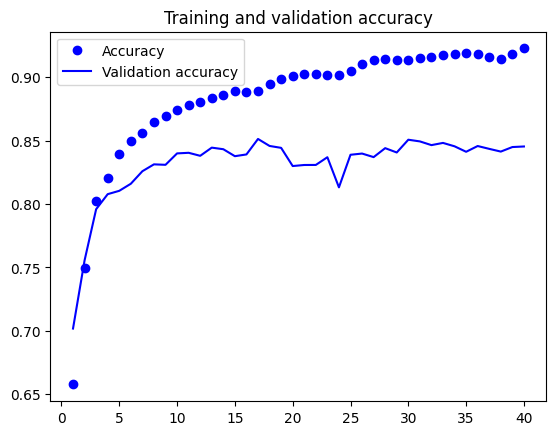

In [40]:
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

We assess the model performance on some images from the test set to see whether the segmentation mask resembles the shape of the cat or dog in the input image. We load the best performing model that was saved before during the training.

Image type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Image tensor data type:  <dtype: 'float32'>
Image tensor shape:  (200, 200, 3)
Image tensor min 0.00 and max 255.00
Mask type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Mask tensor data type:  <dtype: 'uint8'>
Mask tensor shape:  (200, 200, 1)
Mask tensor unique values:  [0 1 2]


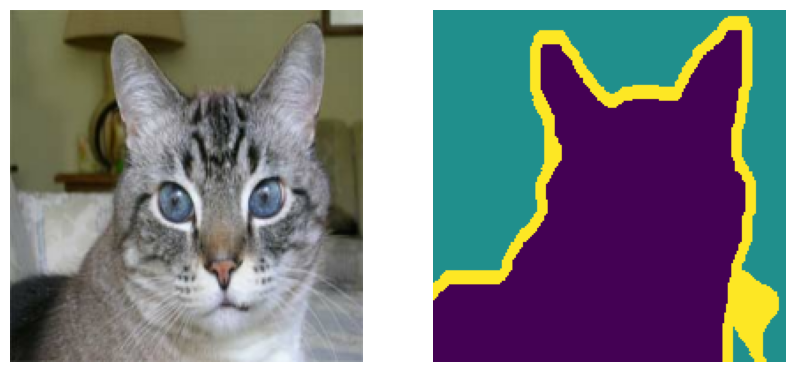

In [41]:
plot_tensor_in_dataset(test_dataset)

In [42]:
best_model = keras.models.load_model("oxford_segmentation.keras")

In [43]:
predicted_masks = best_model.predict(test_dataset)

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 836ms/step


In [44]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

In [45]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

(200, 200, 3)

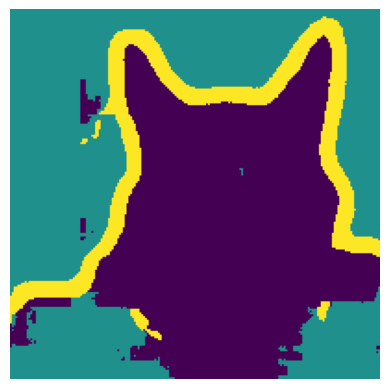

In [46]:
display_mask(predicted_mask)

## References
* [Dumoulin, Visin - A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)